# Imports

In [101]:
!pip install numpy
!pip install yfinance
!pip install matplotlib
!pip install scipy
!pip install seaborn

In [102]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.stats import beta
import seaborn as sns

## Coffee Historic Price Movement

In [103]:
s = yf.download('KC=F', '2016-1-1', '2023-4-1')['Adj Close']

[*********************100%***********************]  1 of 1 completed


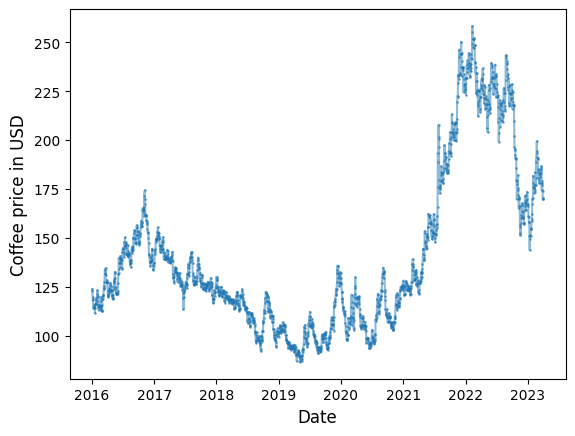

In [104]:
fig, ax = plt.subplots()

ax.plot(s, marker='o', alpha=0.5, ms=1)
ax.set_ylabel('Coffee price in USD', fontsize=12)
ax.set_xlabel('Date', fontsize=12)

plt.show()

## Brazilian Weather Data

### First data set: measuring station codes

In [105]:
first_df = pd.read_csv('FirstDataSet/automatic_stations_codes_2000_2021.csv', sep=';')
first_df_copy = first_df.copy()
print(list(first_df_copy.columns)) 

['REGIAO', 'UF', 'ESTACAO', 'CODIGO', 'LATITUDE', 'LONGITUDE', 'ALTITUDE']


We just want the stations in São Paulo, Rondônia and Paraná.
The respective UF(Unidade da Federação) codes are SP, RO and PR

In [106]:
UF_values = ['SP', 'RO', 'PR']
first_df_specUF = first_df.loc[first_df['UF'].isin(UF_values)]
print(first_df_specUF)

    REGIAO  UF                 ESTACAO CODIGO   LATITUDE  LONGITUDE  ALTITUDE
1       SE  SP               CRIOSFERA   C891 -84.000000 -79.494167   1285.00
13      SE  SP                   BAURU   A705 -22.358056 -49.028889    666.00
33      SE  SP        CAMPOS DO JORDAO   A706 -22.750278 -45.603889   1642.00
34      SE  SP                  FRANCA   A708 -20.580000 -47.380000   1026.00
54      SE  SP     PRESIDENTE PRUDENTE   A707 -22.120000 -51.400000    435.55
..     ...  ..                     ...    ...        ...        ...       ...
563     SE  SP                    TUPA   A768 -21.927222 -50.490278    498.00
564     SE  SP      CACHOEIRA PAULISTA   A769 -22.688889 -45.005556    586.00
597     SE  SP  SAO PAULO - INTERLAGOS   A771 -23.724722 -46.678056    771.00
607     SE  SP               SAO SIMAO   A770 -21.461111 -47.579444    620.00
608      S  PR                 GOIOERE   A825 -24.158333 -53.030556    452.34

[77 rows x 7 columns]


We now want all the individual station codes

In [107]:
station_ids = sorted(first_df_specUF['CODIGO'].values)
print(station_ids)

['A701', 'A705', 'A706', 'A707', 'A708', 'A711', 'A712', 'A713', 'A714', 'A715', 'A716', 'A718', 'A725', 'A726', 'A727', 'A728', 'A729', 'A733', 'A734', 'A735', 'A736', 'A737', 'A738', 'A739', 'A740', 'A741', 'A744', 'A746', 'A747', 'A748', 'A753', 'A755', 'A762', 'A763', 'A764', 'A765', 'A766', 'A767', 'A768', 'A769', 'A770', 'A771', 'A807', 'A818', 'A819', 'A820', 'A821', 'A822', 'A823', 'A824', 'A825', 'A835', 'A842', 'A843', 'A846', 'A847', 'A849', 'A850', 'A855', 'A869', 'A871', 'A872', 'A873', 'A874', 'A875', 'A876', 'A925', 'A938', 'A939', 'A940', 'B803', 'B804', 'B806', 'C891', 'S101', 'S104', 'S110']


### Second data set: weather data measured by the previously stated stations
In the first run the following two blocks were run and then the resulting filtered csv was saved. In the following runs, we just import that saved csv directly (included in this repo) to save time and computer power.

In [108]:
# #The Kaggle states this csv file has 60452376 lines, so we want to know every 1M processed lines
# processed_lines = 0

# # Initialize an empty list to store the filtered data
# filtered_data = []

# # Read the CSV file in chunks
# for chunk in pd.read_csv('FirstDataSet/automatic_weather_stations_inmet_brazil_2000_2021.csv', sep=';', chunksize=1000):  # Adjust chunksize as needed
#     # Filter the chunk
#     filtered_chunk = chunk[chunk['ESTACAO'].isin(station_ids)]
#     # Append the filtered chunk to the list
#     filtered_data.append(filtered_chunk)
#     processed_lines +=1000
#     if processed_lines % 1_000_000 == 0:
#         print(processed_lines)

# # Concatenate all filtered chunks into a single DataFrame
# filtered_df = pd.concat(filtered_data, ignore_index=True)

In [109]:

# # Save the filtered data to a new CSV file
# filtered_df.to_csv('FirstDataSet/filtered_data.csv', index=False)  

In [110]:
filtered_df = pd.read_csv('FirstDataSet/filtered_data.csv', sep=',')

### Now we search for outliers and clean the data a bit to ensure better results

In [111]:
print(filtered_df.columns)

Index(['ESTACAO', 'DATA (YYYY-MM-DD)', 'HORA (UTC)',
       'PRECIPITACAO TOTAL HORARIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (W/m2)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (C)',
       'TEMPERATURA DO PONTO DE ORVALHO (C)',
       'TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)',
       'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)', 'VENTO, DIRECAO HORARIA (gr)',
       'VENTO, RAJADA MAXIMA (m/s)', 'VENTO, VELOCIDADE HORARIA (m/s)'],
      dtype='object')


In [112]:
# Remove the station column as it is not needed anymore
filtered_df = filtered_df.drop(columns=['ESTACAO'])

In [113]:
print(filtered_df.dtypes)

DATA (YYYY-MM-DD)                                         object
HORA (UTC)                                                 int64
PRECIPITACAO TOTAL HORARIO (mm)                          float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    float64
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          float64
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         float64
RADIACAO GLOBAL (W/m2)                                   float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)              float64
TEMPERATURA DO PONTO DE ORVALHO (C)                      float64
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                float64
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                float64
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)          float64
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)          float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 float64
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 float64
UMIDADE RELATIVA DO AR, H

In [114]:
print(filtered_df.max(axis=0))

DATA (YYYY-MM-DD)                                        2021-01-31
HORA (UTC)                                                     2300
PRECIPITACAO TOTAL HORARIO (mm)                                97.2
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)        1033.5
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)              1043.7
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)             1033.3
RADIACAO GLOBAL (W/m2)                                      11586.5
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)                    44.4
TEMPERATURA DO PONTO DE ORVALHO (C)                            39.8
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                      44.7
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                      44.0
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)                40.3
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)                35.3
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                      100.0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)        

In [115]:
print(filtered_df.min(axis=0))

DATA (YYYY-MM-DD)                                        2001-08-30
HORA (UTC)                                                        0
PRECIPITACAO TOTAL HORARIO (mm)                             -9999.0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)       -9999.0
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)             -9999.0
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)            -9999.0
RADIACAO GLOBAL (W/m2)                                      -9999.0
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)                 -9999.0
TEMPERATURA DO PONTO DE ORVALHO (C)                         -9999.0
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                   -9999.0
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                   -9999.0
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)             -9999.0
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)             -9999.0
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                    -9999.0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)        

We can assume all negative values are invalid data except for the temperature and temporal related columns

In [116]:

mask = (filtered_df.drop(columns=['DATA (YYYY-MM-DD)', 'HORA (UTC)',
                                    'TEMPERATURA DO AR - BULBO SECO, HORARIA (C)', 
                                  'TEMPERATURA DO PONTO DE ORVALHO (C)',
                                   'TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)',
                                   'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)',
                                   'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)',
                                   'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)']) >= 0).all(axis=1)
clean_df = filtered_df[mask]

In [117]:
print(clean_df.min(axis=0))

DATA (YYYY-MM-DD)                                        2001-08-31
HORA (UTC)                                                        0
PRECIPITACAO TOTAL HORARIO (mm)                                 0.0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)         825.4
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)               825.6
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)              825.1
RADIACAO GLOBAL (W/m2)                                          0.0
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)                 -9999.0
TEMPERATURA DO PONTO DE ORVALHO (C)                         -9999.0
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                   -9999.0
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                   -9999.0
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)             -9999.0
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)             -9999.0
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        7.0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)        

Now we need to remove the outliers for the temperature based columns.
For this I will use the IQR method since temperatures measurements usually do not follow Normal Distributions.

In [118]:
temp_column_names = ['TEMPERATURA DO AR - BULBO SECO, HORARIA (C)',
                'TEMPERATURA DO PONTO DE ORVALHO (C)',
                'TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)',
                'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)',
                'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)',
                'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)']

# calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = clean_df[temp_column_names].quantile(0.25)
Q3 = clean_df[temp_column_names].quantile(0.75)

# calc IQR
IQR = Q3 - Q1

# define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify appropriate rows
outliers = ((clean_df[temp_column_names] < lower_bound) | 
            (clean_df[temp_column_names] > upper_bound)).any(axis=1)

# remove outliers
clean_df = clean_df[~outliers]

In [119]:
print(clean_df.min(axis=0))

DATA (YYYY-MM-DD)                                        2001-08-31
HORA (UTC)                                                        0
PRECIPITACAO TOTAL HORARIO (mm)                                 0.0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)         825.4
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)               825.6
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)              825.1
RADIACAO GLOBAL (W/m2)                                          0.0
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)                     8.8
TEMPERATURA DO PONTO DE ORVALHO (C)                             3.5
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                       8.8
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                       8.1
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)                 4.4
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)                 2.8
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        7.0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)        

### Get Appropriate Dataframes for study (month and year)

In [120]:
# sum, get max or min values for each day, depending on the column and what makes more sense
final_month_df = clean_df.groupby('DATA (YYYY-MM-DD)').agg({
    'PRECIPITACAO TOTAL HORARIO (mm)': 'sum',
    'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'min',
    'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)': 'min',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)': 'min',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min',
    # Assuming all other columns require the max operation
    **{col: 'max' for col in clean_df.columns if col not in [
        'DATA (YYYY-MM-DD)', 
        'PRECIPITACAO TOTAL HORARIO (mm)', 
        'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 
        'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)', 
        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)',
        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
        'HORA (UTC)']}
})

# convert the Date column to datetime
final_month_df = final_month_df.reset_index()
final_month_df['DATA (YYYY-MM-DD)'] = pd.to_datetime(final_month_df['DATA (YYYY-MM-DD)'])
final_month_df.columns

Index(['DATA (YYYY-MM-DD)', 'PRECIPITACAO TOTAL HORARIO (mm)',
       'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (W/m2)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (C)',
       'TEMPERATURA DO PONTO DE ORVALHO (C)',
       'TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)', 'VENTO, DIRECAO HORARIA (gr)',
       'VENTO, RAJADA MAXIMA (m/s)', 'VENTO, VELOCIDADE HORARIA (m/s)'],
      dtype='object')

In [121]:
# Extract the year from 'DATA (YYYY-MM-DD)'
final_month_df['YEAR'] = final_month_df['DATA (YYYY-MM-DD)'].dt.year

# Group by the extracted year
final_year_df = final_month_df.groupby('YEAR').agg({
    'PRECIPITACAO TOTAL HORARIO (mm)': 'sum',
    'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'min',
    'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)': 'min',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)': 'min',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min',
    # Assuming all other columns require the max operation
    **{col: 'max' for col in final_month_df.columns if col not in [
        'DATA (YYYY-MM-DD)', 
        'PRECIPITACAO TOTAL HORARIO (mm)', 
        'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 
        'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)', 
        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)',
        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
        'YEAR']}
})

# Reset index to make 'Year' a column again
final_year_df = final_year_df.reset_index()
final_year_df.columns

Index(['YEAR', 'PRECIPITACAO TOTAL HORARIO (mm)',
       'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (W/m2)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (C)',
       'TEMPERATURA DO PONTO DE ORVALHO (C)',
       'TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)', 'VENTO, DIRECAO HORARIA (gr)',
       'VENTO, RAJADA MAXIMA (m/s)', 'VENTO, VELOCIDADE HORARIA (m/s)'],
      dtype='object')

Now we can plot, for example the precipitation.

In [122]:
def singleYplot(x_data, y_data, dataframe, monthly=True):   
    plt.figure(figsize=(12, 6))

    # Plotting with seaborn
    sns.lineplot(x=x_data, y=y_data, data=dataframe)

    if monthly:
        # Format the x-axis to show only month and year
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

        # Optionally, set major ticks to be at the start of every month
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    # Rotate the x-axis labels for better readability (optional)
    plt.xticks(rotation=45)

    plt.show()

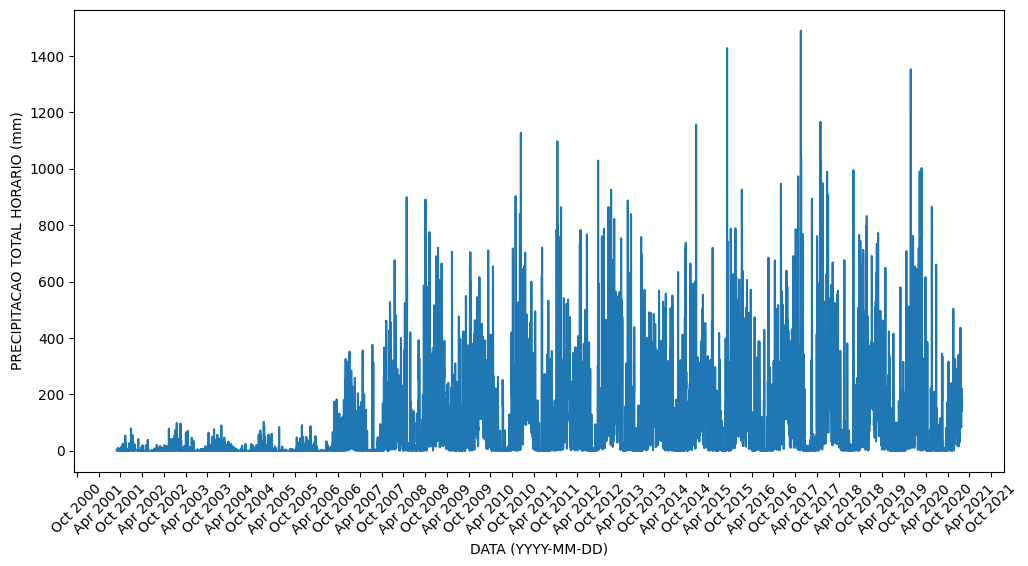

In [123]:
singleYplot('DATA (YYYY-MM-DD)', 'PRECIPITACAO TOTAL HORARIO (mm)', final_month_df)

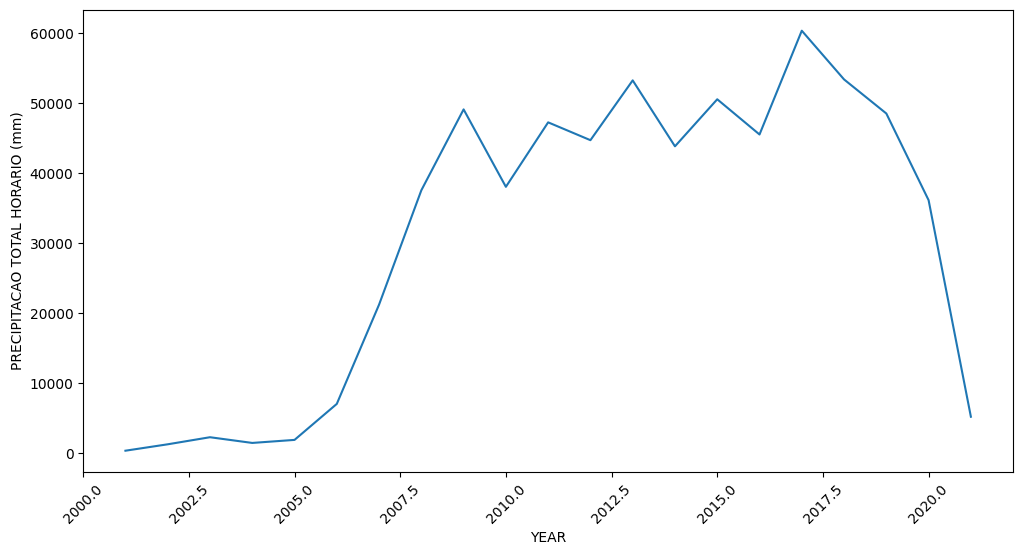

In [124]:
singleYplot('YEAR', 'PRECIPITACAO TOTAL HORARIO (mm)', final_year_df, monthly=False)

# Price vs Measurements - Plots and Conclusions

In [125]:
start_date = '2001-08-30'
end_date = '2021-01-31'
s = yf.download('KC=F', start_date, end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [126]:
# Convert the index of s (dates) to a column for consistency with the DataFrame
s = s.reset_index()
s['DATA (YYYY-MM-DD)'] = pd.to_datetime(s['Date'])

## For Monthly Values

### Correlation Matrix to see what would be interesting to plot

DATA (YYYY-MM-DD)                                        0.345396
PRECIPITACAO TOTAL HORARIO (mm)                          0.204084
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)        -0.156033
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)               -0.253328
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)         -0.211728
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                -0.313097
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0.562479
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0.562485
RADIACAO GLOBAL (W/m2)                                   0.391698
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)              0.407791
TEMPERATURA DO PONTO DE ORVALHO (C)                      0.443148
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                0.406001
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)          0.435779
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0.409680
UMIDADE RELATIVA DO AR, HORARIA (%)                      0.419989
VENTO, DIR

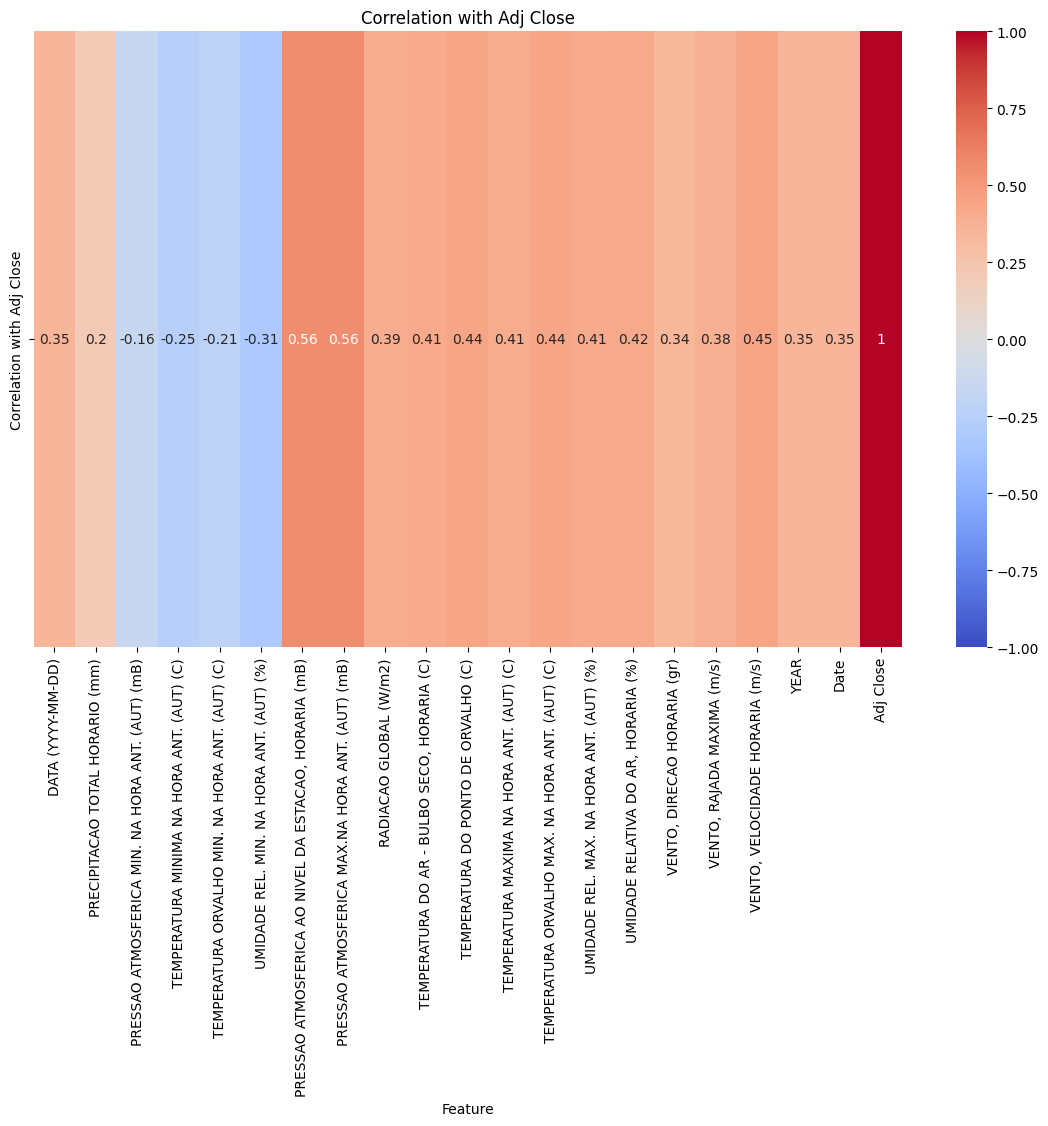

In [127]:
# Merge the two DataFrames on the 'Date' column
merged_df = pd.merge(final_month_df, s, on='DATA (YYYY-MM-DD)', how='inner')  # 'inner' keeps only dates that are in both DataFrames

# Calculate correlation between 'Value' and 'Adj Close'
correlation_matrix = merged_df.corrwith(merged_df['Adj Close'])
print(correlation_matrix)
# Convert Series to DataFrame for easier plotting
correlation_df = correlation_matrix.reset_index()
correlation_df.columns = ['Feature', 'Correlation with Adj Close']

# Create the plot
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df.set_index('Feature').T, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation with Adj Close')
plt.show()

So the best correlations are:
- Positive: PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB) ---> 0.562485
- Negative: UMIDADE REL. MIN. NA HORA ANT. (AUT) (%) ---> -0.313097
  
For brevity, we will focus only on these two. 

Function to create plots to compare two different column values through time, in order to visually understand the correlation.

In [138]:
def create_correlation_plots(x_column, y_column1, y_column2, full_data, 
                            label_line1, label_line2, 
                            ylabel1, ylabel2, 
                            title,
                            mouthly=True):
    # Create a wider plot
    fig, ax1 = plt.subplots(figsize=(12, 6))  # Adjust the size as needed

    # Plot the previous data on the left y-axis
    sns.lineplot(x=x_column, y=y_column1, data=full_data, label=label_line1, color='b')

    # Format the x-axis to show only month and year on ax1
    if mouthly:
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_ylabel(ylabel1, color='b')  # Label for the left y-axis
    ax1.tick_params(axis='y', labelcolor='b')  # Color the ticks on the left y-axis

    # Create a second y-axis on the right for the coffee futures
    ax2 = ax1.twinx()
    sns.lineplot(x=x_column, y=y_column2, data=s, ax=ax2, label=label_line2, color='r')
    ax2.set_ylabel(ylabel2, color='r')  # Label for the right y-axis
    ax2.tick_params(axis='y', labelcolor='r')  # Color the ticks on the right y-axis

    # Add title and show the plot with legend
    plt.title(title)
    fig.tight_layout()  # Adjust layout to ensure everything fits
    plt.show()

For an example of what a lower correlation looks like, we can analyze the coffee price variation with the precipitation amount (PRECIPITACAO TOTAL HORARIO (mm)), which is usually, at least in my case, what one would think of as the most obvious correlation for a plant based product. 

C:\Users\Joao\AppData\Local\Temp\ipykernel_23832\1033857194.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


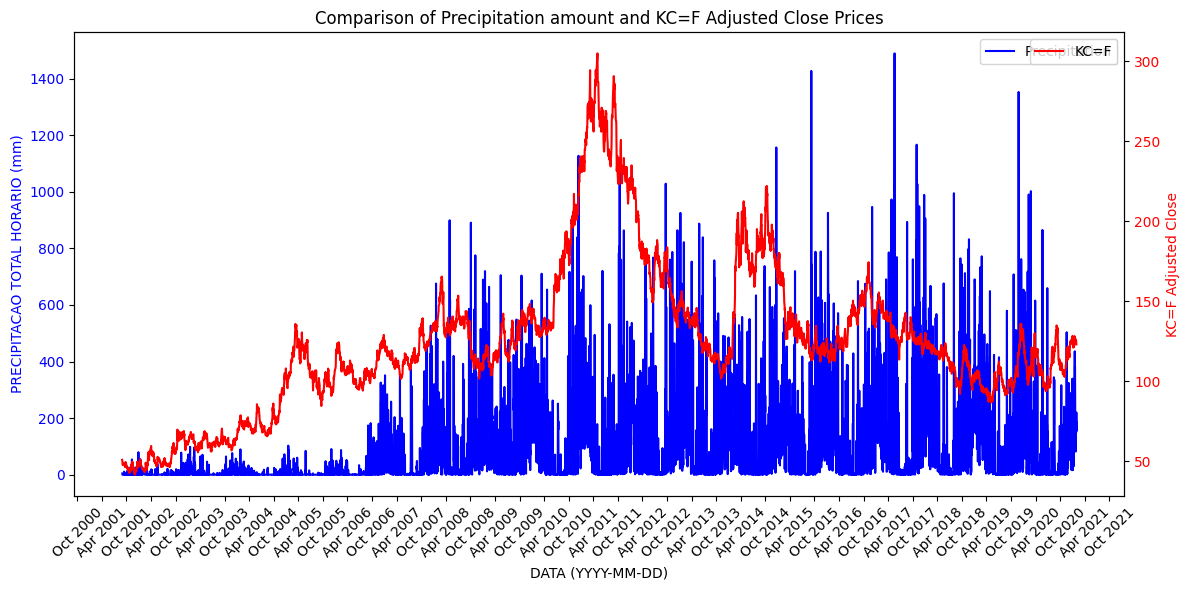

In [129]:
create_correlation_plots('DATA (YYYY-MM-DD)', 'PRECIPITACAO TOTAL HORARIO (mm)', 'Adj Close', 
                        final_month_df, 
                        'Precipitation', 'KC=F', 
                        'PRECIPITACAO TOTAL HORARIO (mm)', 'KC=F Adjusted Close', 
                        'Comparison of Precipitation amount and KC=F Adjusted Close Prices')

Now lets do it for our greatest positive correlation:

C:\Users\Joao\AppData\Local\Temp\ipykernel_23832\1033857194.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


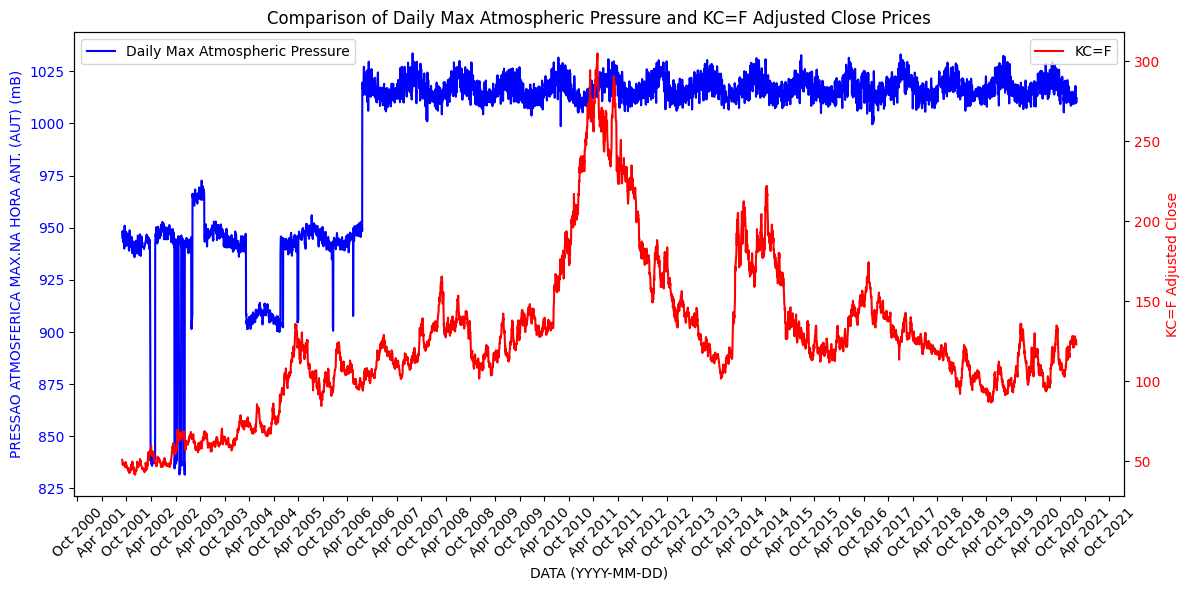

In [130]:
create_correlation_plots('DATA (YYYY-MM-DD)', 'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 'Adj Close', 
                        final_month_df, 
                        'Daily Max Atmospheric Pressure', 'KC=F', 
                        'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 'KC=F Adjusted Close', 
                        'Comparison of Daily Max Atmospheric Pressure and KC=F Adjusted Close Prices')

Now lets do it for our greatest negative correlation:

C:\Users\Joao\AppData\Local\Temp\ipykernel_23832\1033857194.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


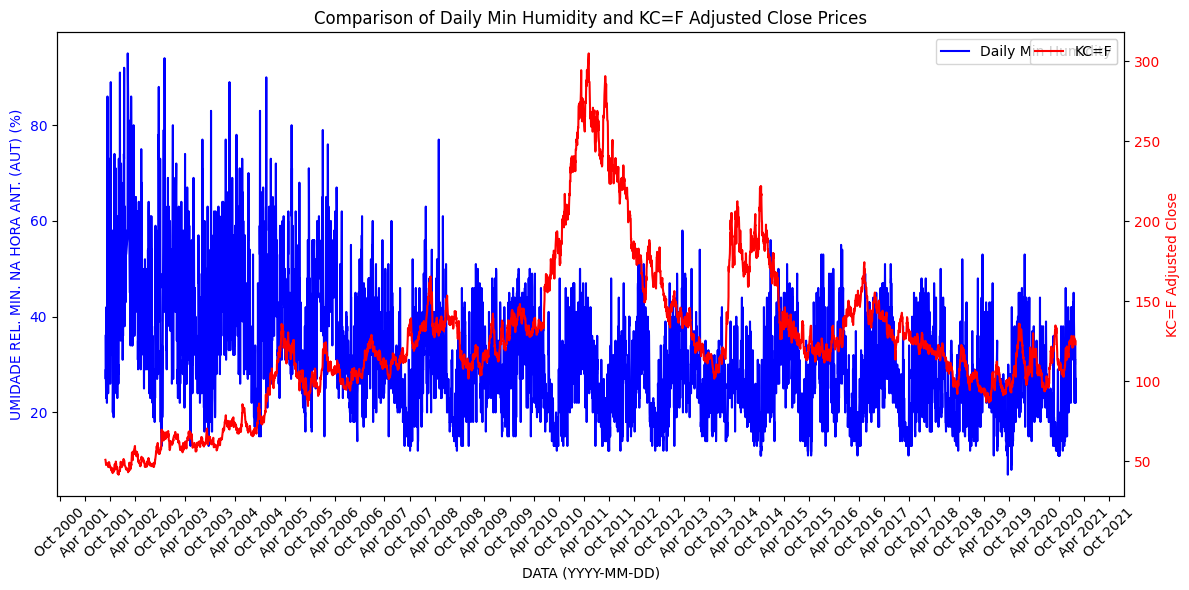

In [131]:
create_correlation_plots('DATA (YYYY-MM-DD)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'Adj Close', 
                        final_month_df, 
                        'Daily Min Humidity', 'KC=F', 
                        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'KC=F Adjusted Close', 
                        'Comparison of Daily Min Humidity and KC=F Adjusted Close Prices')

## For Yearly Values

In [135]:
# get maximum yearly values for the Futures prices

s['YEAR'] = s['Date'].dt.year

s_year = s.loc[s.groupby('YEAR')['Adj Close'].idxmax()].drop(columns=['Date', 'DATA (YYYY-MM-DD)'])
s_year

,Adj Close,Year,YEAR
0,50.799999,2001,2001
273,69.699997,2002,2002
498,70.349998,2003,2003
821,107.949997,2004,2004
869,135.750000,2005,2005
1321,128.899994,2006,2006
1520,139.300003,2007,2007
1614,165.399994,2008,2008
2067,148.199997,2009,2009
2329,240.500000,2010,2010


c:\Users\Joao\Desktop\coffee-trade\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Joao\Desktop\coffee-trade\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


YEAR                                                     0.357817
PRECIPITACAO TOTAL HORARIO (mm)                          0.570880
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)        -0.264708
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)               -0.230006
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)         -0.036754
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                -0.253975
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0.588777
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0.588804
RADIACAO GLOBAL (W/m2)                                   0.587680
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)              0.409388
TEMPERATURA DO PONTO DE ORVALHO (C)                      0.487242
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                0.429909
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)          0.481493
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0.512831
UMIDADE RELATIVA DO AR, HORARIA (%)                      0.512831
VENTO, DIR

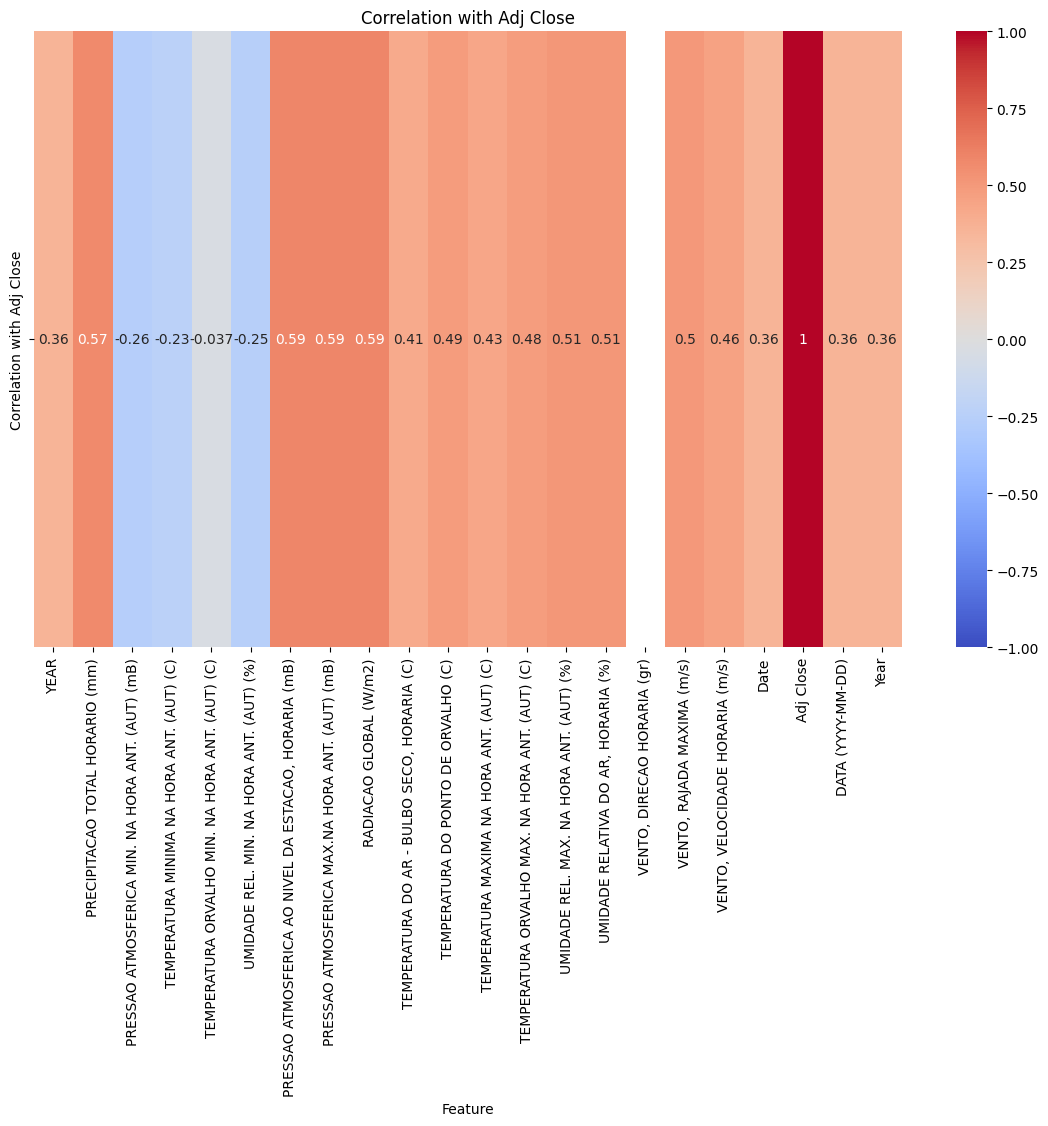

In [136]:
# Merge the two DataFrames on the 'Date' column
merged_df = pd.merge(final_year_df, s, on='YEAR', how='inner')  # 'inner' keeps only dates that are in both DataFrames

# Calculate correlation between 'Value' and 'Adj Close'
correlation_matrix = merged_df.corrwith(merged_df['Adj Close'])
print(correlation_matrix)
# Convert Series to DataFrame for easier plotting
correlation_df = correlation_matrix.reset_index()
correlation_df.columns = ['Feature', 'Correlation with Adj Close']

# Create the plot
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df.set_index('Feature').T, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation with Adj Close')
plt.show()

C:\Users\Joao\AppData\Local\Temp\ipykernel_23832\3065704608.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


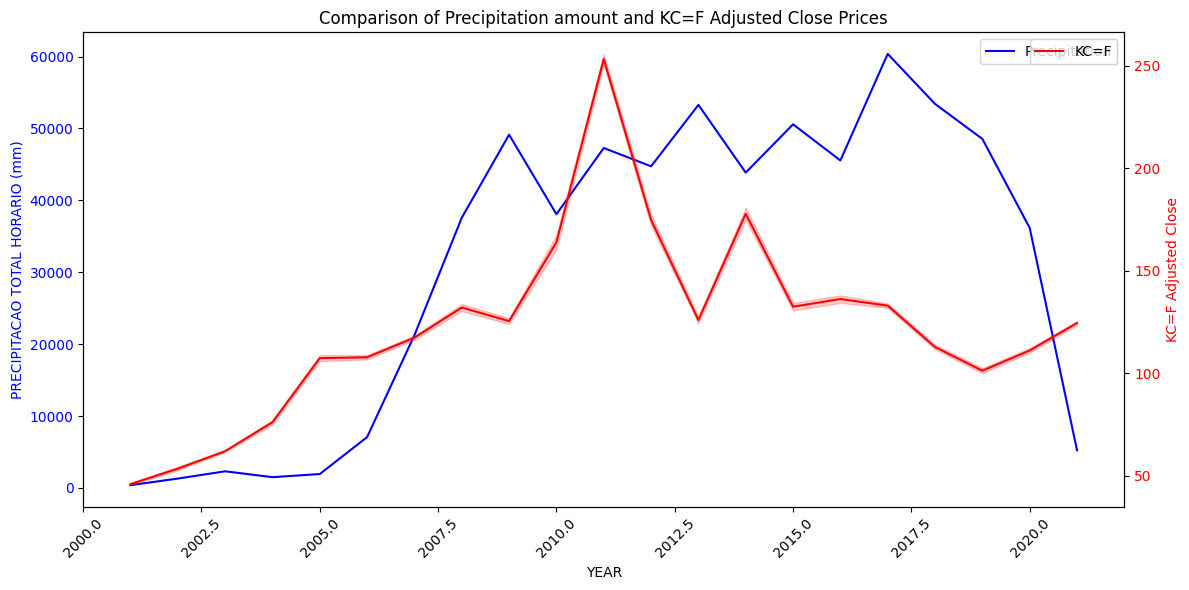

In [139]:
create_correlation_plots('YEAR', 'PRECIPITACAO TOTAL HORARIO (mm)', 'Adj Close', 
                        final_year_df, 
                        'Precipitation', 'KC=F', 
                        'PRECIPITACAO TOTAL HORARIO (mm)', 'KC=F Adjusted Close', 
                        'Comparison of Precipitation amount and KC=F Adjusted Close Prices', 
                        mouthly=False)